In [1]:
import numpy as np
import pandas as pd
import torch
from gensim.models import Word2Vec

# Autoreload extensions
%load_ext autoreload
%autoreload 2

In [2]:
word2VecModel =  Word2Vec.load("..\model_weights\word2vec.model")
#print embedding dimensions
EMBEDDING_SIZE = word2VecModel.wv.vectors.shape[1]
print(f"EMBEDDING_SIZE: {EMBEDDING_SIZE}")
print(f"Vocab Size: {word2VecModel.wv.vectors.shape[0]}")

EMBEDDING_SIZE: 100
Vocab Size: 1968


In [4]:
from nlpChess.utils.DatasetLoader import loadDataset

dataset = loadDataset()

In [7]:
dataset_train = dataset['train'].to_pandas()[['Moves', 'Result']]
dataset_test = dataset['test'].to_pandas()[['Moves', 'Result']]
dataset_val = dataset['validation'].to_pandas()[['Moves', 'Result']]

In [8]:
dataset_train

,Moves,Result
0,"[e2e4, g7g6, g1f3, f8g7, d2d4, d7d6, f1d3, e7e...",1-0
1,"[e2e4, c7c6, d2d3, d7d6, g2g3, g8f6, h2h4, e7e...",0-1
2,"[e2e4, c7c5, g1f3, d7d6, d2d4, c5d4, f3d4, g8f...",1/2-1/2
3,"[d2d4, d7d6, g1f3, g8f6, c2c4, g7g6, e2e3, f8g...",0-1
4,"[e2e4, g7g6, d2d4, d7d5, e4e5, c7c5, d4c5, f8g...",0-1
...,...,...
69995,"[d2d4, d7d5, g1f3, g8f6, e2e3, e7e6, f1e2, c7c...",1/2-1/2
69996,"[d2d4, g8f6, g1f3, e7e6, c2c4, d7d5, b1c3, c7c...",1-0
69997,"[d2d4, g8f6, g1f3, e7e6, c1g5, c7c5, e2e3, f8e...",1/2-1/2
69998,"[g1f3, g8f6, c2c4, g7g6, d2d4, f8g7, b1c3, d7d...",1/2-1/2


In [9]:
# index the result as 0 for loss, 1 for draw, and 2 for win
dataset_train['Result'] = dataset_train['Result'].map({'0-1': 0, '1/2-1/2': 1, '1-0': 2})
dataset_test['Result'] = dataset_test['Result'].map({'0-1': 0, '1/2-1/2': 1, '1-0': 2})
dataset_val['Result'] = dataset_val['Result'].map({'0-1': 0, '1/2-1/2': 1, '1-0': 2})

In [10]:
from torch.utils.data import Dataset, DataLoader
from typing import Dict

class OutcomeClassificationDataset(Dataset):
    def __init__(self, data, word2VecModel:Word2Vec):
        self.data = data
        self.word2VecModel:Word2Vec = word2VecModel

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sent = self.data[idx]['Moves']
        # words = [self.word2VecModel.wv[token] if token in self.word2VecModel.wv.key_to_index else np.zeros(EMBEDDING_SIZE) for token in sent]
        words = [self.word2VecModel.wv[token] if token in self.word2VecModel.wv.key_to_index else np.zeros(EMBEDDING_SIZE) for token in sent]
        label = self.data[idx]['Result']
        return torch.tensor(words, dtype=torch.float32), torch.tensor(label, dtype=torch.float32)
    
dataset_train = OutcomeClassificationDataset(dataset_train.to_dict(orient='records'), word2VecModel)
dataset_val = OutcomeClassificationDataset(dataset_val.to_dict(orient='records'), word2VecModel)
dataset_test = OutcomeClassificationDataset(dataset_test.to_dict(orient='records'), word2VecModel)

In [11]:
dataset_test[0][0].shape, dataset_test[0][1].shape

C:\Users\marti\AppData\Local\Temp\ipykernel_3476\1233293205.py:17: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:257.)
  return torch.tensor(words, dtype=torch.float32), torch.tensor(label, dtype=torch.float32)


(torch.Size([135, 100]), torch.Size([]))

In [67]:
def collate_fn(batch):
    # batch: list of tuples (word_tensor, tag_tensor)
    # Get input sentences
    moves = [item[0] for item in batch]
    # Get labels
    outcomes = [item[1] for item in batch]
    # Get maximum length in the batch
    lengths = [len(s) for s in moves]
    max_len = max(lengths)

    # Pad shorter sentences to let the input tensors all have the same size
    padded_moves = []
    for s in moves:
        pad_len = max_len - len(s)
        # Padding uses index 0 both for words and labels
        padded_moves.append(torch.cat([s, torch.zeros((pad_len, s.shape[1]), dtype=torch.float32)]))

    #
    return torch.stack(padded_moves), torch.stack(outcomes), lengths

BATCH_SIZE = 32
train_loader = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(dataset_val, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

In [68]:
for batch in train_loader:
    moves, outcomes, lengths = batch
    print("Moves shape:", moves.shape)
    print("Outcomes shape:", outcomes.shape)
    print("Lengths:", lengths)
    break

Moves shape: torch.Size([32, 398, 100])
Outcomes shape: torch.Size([32])
Lengths: [123, 150, 348, 137, 185, 135, 153, 110, 163, 105, 151, 55, 176, 215, 162, 165, 128, 143, 317, 220, 175, 143, 376, 121, 165, 221, 332, 86, 126, 398, 172, 99]


In [69]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [ ]:
class BiLSTM_NER(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, num_outcomes):
        super(BiLSTM_NER, self).__init__()
        # Bidirectional LSTM; we set batch_first=True to have input like [batch, seq_len, embedding_dim]
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, bidirectional=False, batch_first=True)
        # Fully connected layer to map hidden state coming from LSTM to output labels
        # (the hidden state is a concatenation of two LSTM outputs since it is bidirectional)
        self.fc = nn.Linear(hidden_dim, num_outcomes)

    def forward(self, x):
        # x: [batch_size, seq_len]
        lstm_out, _ = self.lstm.forward(x)   # lstm_out: [batch_size, seq_len, hidden_dim*2]
        logits = self.fc(lstm_out[:, -1, :])        # logits: [batch_size, num_tags]
        probabs = torch.nn.functional.softmax(logits, dim=-1)  # probabs: [batch_size, num_tags]
        return probabs, logits

In [71]:
# Models parameters
HIDDEN_DIM = 128
EPOCHS = 10

In [ ]:
model = BiLSTM_NER(EMBEDDING_SIZE, HIDDEN_DIM, 3)

In [73]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [74]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [75]:
model = model.to(device)

In [81]:
from tqdm import tqdm
from sklearn.metrics import accuracy_score, recall_score, f1_score
import logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s', filename='training.log')


history = []
best_val_loss = float('inf')
patience = 3
patience_counter = 0

for epoch in range(EPOCHS):
    # Training
    model.train()
    epoch_loss = 0
    for inputs, targets, lengths in tqdm(train_loader):
        optimizer.zero_grad()
        inputs = inputs.to(device)
        targets = targets.to(device)
        outputs, logits = model(inputs)
        # CrossEntropyLoss expects targets to be of type Long and 1D (class indices)
        loss = criterion(logits, targets.long())
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        history.append(loss.item())
        # Log training loss
        logging.info(f"Epoch {epoch+1}/{EPOCHS} - Batch Loss: {loss.item():.4f}")
    avg_train_loss = epoch_loss / len(train_loader)

    # Validation
    model.eval()
    val_loss = 0
    all_preds = []
    all_true = []
    with torch.no_grad():
        for inputs, targets, lengths in tqdm(val_loader, desc="Validation"):
            inputs = inputs.to(device)
            targets = targets.to(device) # Ensure targets are of shape [batch_size, num_classes]
            outputs, logits = model(inputs)
            loss = criterion(logits, targets.long())
            val_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            true = targets
            all_preds.extend(preds.cpu().numpy())
            all_true.extend(true.cpu().numpy())
            #log
            logging.info(f"Validation Batch Loss: {loss.item():.4f}")
    avg_val_loss = val_loss / len(val_loader)

    # Compute metrics
    val_accuracy = accuracy_score(all_true, all_preds)
    val_recall = recall_score(all_true, all_preds, average='weighted')
    val_f1 = f1_score(all_true, all_preds, average='weighted')

    print(f"Epoch {epoch+1}/{EPOCHS} - Train Loss: {avg_train_loss:.4f} - Val Loss: {avg_val_loss:.4f} - Val Acc: {val_accuracy:.4f} - Val Recall: {val_recall:.4f} - Val F1: {val_f1:.4f}")

    # Early stopping check
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        best_model_state = model.state_dict()
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            model.load_state_dict(best_model_state)
            break

Validation: 100%|██████████| 625/625 [01:02<00:00, 10.00it/s]


Epoch 1/10 - Train Loss: 0.1898 - Val Loss: 0.1791 - Val Acc: 0.9304 - Val Recall: 0.9304 - Val F1: 0.9295


Validation: 100%|██████████| 625/625 [01:02<00:00,  9.98it/s]


Epoch 2/10 - Train Loss: 0.1564 - Val Loss: 0.1543 - Val Acc: 0.9386 - Val Recall: 0.9386 - Val F1: 0.9386


Validation: 100%|██████████| 625/625 [01:03<00:00,  9.78it/s]


Epoch 3/10 - Train Loss: 0.1324 - Val Loss: 0.1460 - Val Acc: 0.9421 - Val Recall: 0.9421 - Val F1: 0.9423


Validation: 100%|██████████| 625/625 [01:03<00:00,  9.80it/s]


Epoch 4/10 - Train Loss: 0.1152 - Val Loss: 0.1373 - Val Acc: 0.9448 - Val Recall: 0.9448 - Val F1: 0.9448


Validation: 100%|██████████| 625/625 [01:03<00:00,  9.82it/s]


Epoch 5/10 - Train Loss: 0.1045 - Val Loss: 0.1372 - Val Acc: 0.9458 - Val Recall: 0.9458 - Val F1: 0.9458


Validation: 100%|██████████| 625/625 [01:02<00:00,  9.98it/s]


Epoch 6/10 - Train Loss: 0.0920 - Val Loss: 0.1410 - Val Acc: 0.9447 - Val Recall: 0.9447 - Val F1: 0.9439


Validation: 100%|██████████| 625/625 [01:05<00:00,  9.59it/s]


Epoch 7/10 - Train Loss: 0.0840 - Val Loss: 0.1332 - Val Acc: 0.9505 - Val Recall: 0.9505 - Val F1: 0.9501


Validation: 100%|██████████| 625/625 [01:03<00:00,  9.83it/s]


Epoch 8/10 - Train Loss: 0.0769 - Val Loss: 0.1406 - Val Acc: 0.9498 - Val Recall: 0.9498 - Val F1: 0.9496


Validation: 100%|██████████| 625/625 [01:03<00:00,  9.91it/s]


Epoch 9/10 - Train Loss: 0.0713 - Val Loss: 0.1357 - Val Acc: 0.9489 - Val Recall: 0.9489 - Val F1: 0.9488


Validation: 100%|██████████| 625/625 [01:01<00:00, 10.23it/s]

Epoch 10/10 - Train Loss: 0.0639 - Val Loss: 0.1469 - Val Acc: 0.9504 - Val Recall: 0.9504 - Val F1: 0.9501
Early stopping triggered.


In [111]:
model.state_dict()

OrderedDict([('lstm.weight_ih_l0',
              tensor([[ 0.0379,  0.0576,  0.2621,  ...,  0.6185,  0.2249, -0.4344],
                      [-0.3193, -0.0248, -0.0606,  ...,  0.5082, -0.2285,  0.2018],
                      [-0.1781,  0.0736, -0.1689,  ...,  0.1571, -0.1663,  0.2531],
                      ...,
                      [-0.1958, -0.3801, -0.0820,  ..., -0.0591,  0.0698,  0.2087],
                      [-0.0259,  0.3731,  0.2491,  ...,  0.4076,  0.3222, -0.2167],
                      [-0.3850,  0.3355, -0.0481,  ...,  0.0717,  0.0454,  0.3318]],
                     device='cuda:0')),
             ('lstm.weight_hh_l0',
              tensor([[ 0.2676, -0.1528,  0.3156,  ...,  0.3662,  0.1730, -0.1334],
                      [ 0.3435,  0.2843,  0.1839,  ...,  0.1983,  0.2519,  0.0187],
                      [ 0.0854, -0.0240, -0.1179,  ...,  0.2667, -0.0907,  0.0903],
                      ...,
                      [ 0.0441, -0.0272,  0.1913,  ...,  0.1713,  0.6157,  0.21

In [84]:
# save the model
torch.save(model.state_dict(), "C:\\Users\\marti\\NLP-Project\\model_weights\\bilstm_ner_model.pth")

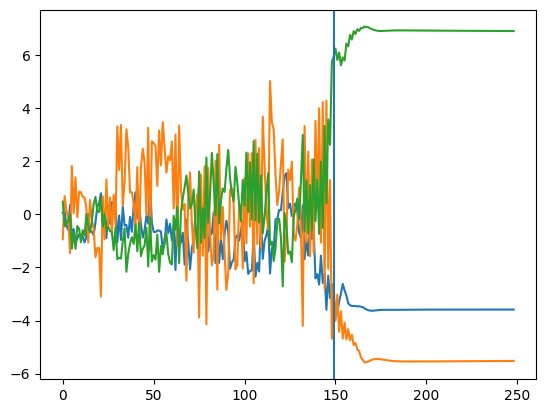

In [109]:
import matplotlib.pyplot as plt

x, y = test_loader.dataset[3]
x = x.unsqueeze(0).to(device)  # Add batch dimension
game_length = x.shape[1]
# cocatenate 0s to the end of x to match the input size of the model
x = torch.cat([x, torch.zeros((1, 100, x.shape[-1]), dtype=torch.float32).to(device)], dim=1)
logits = model.fc(model.lstm.forward(x)[0]).detach().cpu()[0]
plt.plot(logits, label='Logits')
plt.axvline(game_length)




In [26]:
historyReshaped = np.array(history).reshape(-1, len(train_loader))
print(historyReshaped.shape)

(10, 4000)


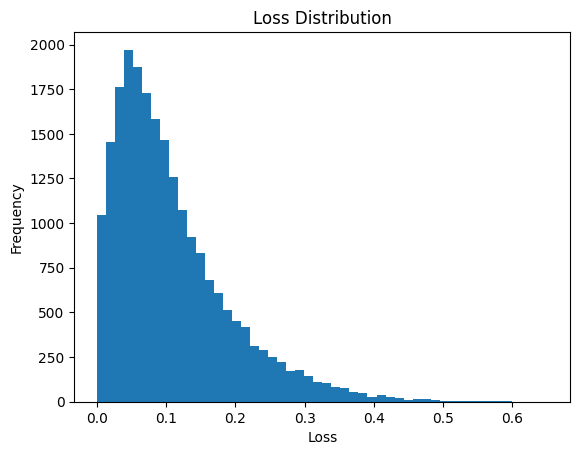

In [90]:
# plot the distribution of the loss
import matplotlib.pyplot as plt

plt.hist(history[:-1], bins=50)
plt.xlabel('Loss')
plt.ylabel('Frequency')
plt.title('Loss Distribution')
plt.show()

In [28]:
model.eval()
with torch.no_grad():
    # Get the first 10 samples from the validation set
    sample_batch = [dataset_val[i] for i in range(10)]
    moves, outcomes, lengths = collate_fn(sample_batch)
    moves = moves.to(device)
    outputs = model(moves)
    preds = outputs.cpu().numpy()
    true_labels = torch.argmax(outcomes, dim=1).numpy()
    print("Predictions:", preds)
    print("True labels:", true_labels)

Predictions: [[9.9998927e-01 1.0670213e-05 1.6567036e-08]
 [2.5982295e-06 9.9999738e-01 1.6333949e-08]
 [9.9999106e-01 3.5417727e-07 8.5965412e-06]
 [3.9829606e-06 4.6776036e-05 9.9994934e-01]
 [2.4616584e-06 9.9999750e-01 1.3264348e-08]
 [2.0791574e-06 2.4961992e-05 9.9997306e-01]
 [2.5819145e-06 9.9999738e-01 1.5944439e-08]
 [2.8242371e-06 9.9999714e-01 2.2404645e-08]
 [2.9073287e-06 9.9999702e-01 2.4967550e-08]
 [2.6579933e-06 9.9999738e-01 1.7815625e-08]]
True labels: [0 1 0 2 1 2 1 1 2 1]


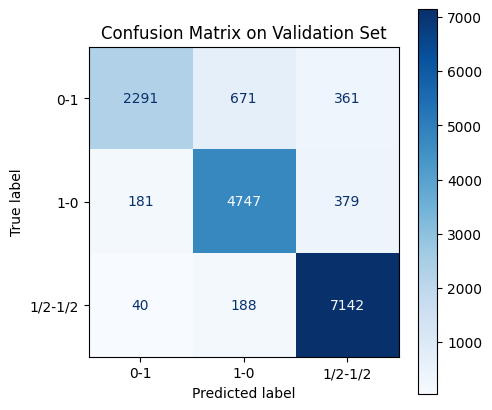

In [29]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

import matplotlib.pyplot as plt

# Get predictions and true labels for the entire validation set
model.eval()
all_preds = []
all_true = []

with torch.no_grad():
    for inputs, targets, lengths in val_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        outputs = model(inputs)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        true = torch.argmax(targets, dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_true.extend(true)

cm = confusion_matrix(all_true, all_preds)
labels = ['0-1', '1-0', '1/2-1/2']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(5,5))
disp.plot(ax=ax, cmap='Blues', values_format='d')
plt.title("Confusion Matrix on Validation Set")
plt.show()

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

# Plot a weighted confusion matrix
# Compute class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(all_true), y=all_true)
# Normalize weights for display
norm_weights = class_weights / class_weights.sum()
norm_weights = norm_weights[:, np.newaxis]  # Reshape to 2D for display

norm_weights_matrix = norm_weights @ norm_weights.T

cm_weighted = cm * norm_weights_matrix
cm_weighted = cm_weighted.astype('float') / cm_weighted.sum()

# Plot weighted confusion matrix
fig, ax = plt.subplots(figsize=(5,5))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_weighted, display_labels=labels)
disp.plot(ax=ax, cmap='Blues', values_format='.2f')
plt.title("Weighted Confusion Matrix on Validation Set")
plt.show()

In [ ]:
print("Sum of diagonal of weighted confusion matrix:", np.trace(cm_weighted))

In [ ]:
#Comupte accuracy, recall and f1 score on validation set
from sklearn.metrics import classification_report
report = classification_report(all_true, all_preds, target_names=labels)
print(report)

# Plot the metrics
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(history, label='Loss')

plt.axhline(y=best_val_loss, color='r', linestyle='--', label='Best Validation Loss')
plt.title('Training Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Save the model
torch.save(model.state_dict(), 'bilstm_model.pth')

# Classification of the outcome cause

In [ ]:
df_cause = pd.read_sql_query("SELECT id, termination FROM games", connection)

In [ ]:
df_cause.head()

In [ ]:
df_moves_grouped.head()

In [ ]:
df_moves_cause = pd.merge(df_moves_grouped, df_cause, left_on='game_id', right_on='id', how='left').drop(columns=['id', 'game_id'])
df_moves_cause.head()

In [ ]:
# One hot encoding the termination column
one_hot_termination = pd.get_dummies(df_moves_cause['termination'])
df_cause_one_hot = df_moves_cause.copy()
df_cause_one_hot['one_hot_termination'] = one_hot_termination.values.tolist()
# drop the termination column
df_cause_one_hot = df_cause_one_hot.drop(columns=['termination'])
df_cause_one_hot.head()

In [ ]:
# Cross validation split the dataset
from sklearn.model_selection import train_test_split
df_train_cause, df_test_cause = train_test_split(df_cause_one_hot, test_size=0.2, random_state=42)
df_train_cause, df_val_cause  = train_test_split(df_train_cause, test_size=0.2, random_state=42)
df_train_cause.shape, df_val_cause.shape, df_test_cause.shape